## Chapter 8. Poisson Processes

The world cup problem

- each team has $\lambda$ a goal-scoring rate (goals per game)
- goals are possible at any time in the game so the per minute probability of a goal is $\lambda/90$

Using the Poisson distribution then the probability of scoring $k$ goals is 

$$
e^{-\lambda}\frac{\lambda^k}{k!}
$$

In [54]:
from scipy.stats import poisson
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

Then use the 'frozen' random variable above to estimate the probability of a specific value of $k$. In this context, this is equivalent to estimating the probability of 4 goals from a team that scores on average 1.4 goals per game.

In [2]:
k = 4
dist.pmf(4)

0.039471954028253146

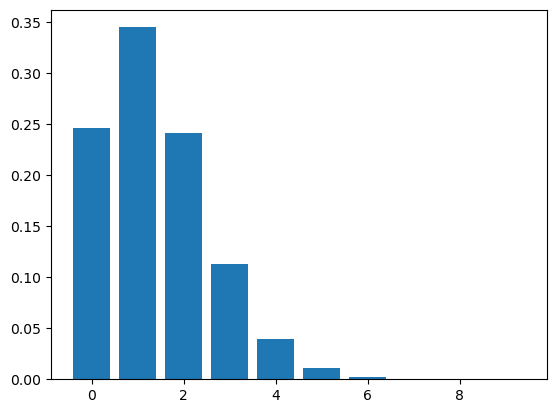

In [8]:
from empiricaldist import Pmf
import numpy as np
import matplotlib.pyplot as plt

def make_poisson_pmf(lam, qs):
    """
    Generate a probability mass function for a Poisson
    with mean 'lam' over a range (array) of values 'qs'
    """
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)
pmf_goals.bar()

Now being a Bayesian, then we're really not that interested in the _forward_ problem. We actually want to estimate the goal scoring rate given a number of _observed_ goals: the _inverse_ problem.

So we need to conjecture a set of hypotheses that represents the possible values of $\lambda$ and then we need to prior that assigns a (prior) probability to each hypothesis.

Here we choose to use the **gamma** distribution to model the continuous range of possible hypotheses (i.e. a continuous non-negative number). The shape of the gamma is defined by a single parameter $\alpha$ that represents its mean. And it so happens that the gamma is the conjugate prior of the Poisson.

<AxesSubplot:>

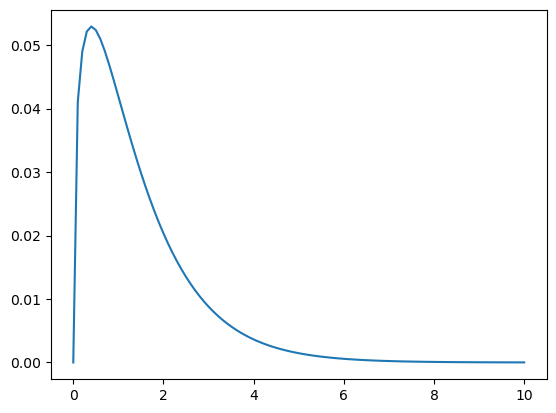

In [55]:
from scipy.stats import gamma

# mean of gamma is our best guess estimate of goals per game 
# given that's the average from previous world cup matches
alpha = 1.4 
qs = np.linspace(0,10,101) # hypothesis grid
ps = gamma(alpha).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()

prior.plot()


### The update

Given an observed number of goals (4) then how does this change our the _prior_ probability distribution over the range of hypotheses.

Here we need to calculate the probabilty of the data (4 goals) for each hypothesis (i.e. the _likelihood_) which we then multiply by the prior to find the posterior.

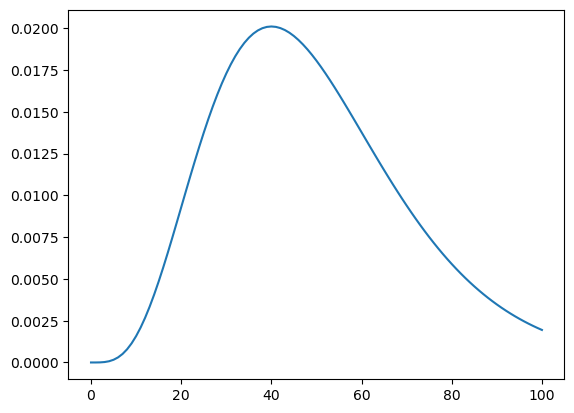

In [56]:
# worked example by hand after seeing a team score 4 goals
hypos = np.linspace(0, 10, 101)
likelihood_unnorm = poisson([hypos]).pmf(4)
likelihood = likelihood_unnorm / np.sum(likelihood_unnorm)
plt.plot(likelihood[0]) # <- used [0] b/c array is nested via poisson([])

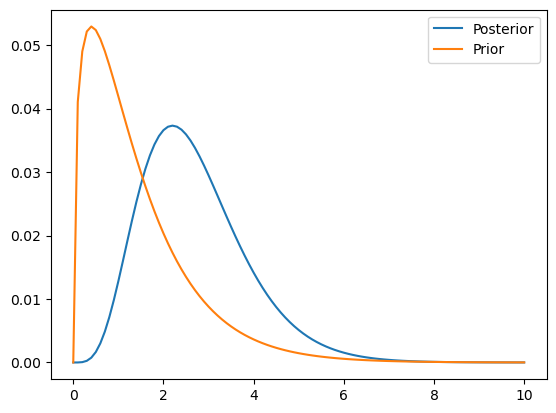

In [86]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood"""
    k = data
    lams = pmf.qs # hypotheses over a grid
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    # pmf.normalize() # <- normalize returns a scaler??
    # do this by hand your self
    return pmf / pmf.sum()

# prior
alpha = 1.4 
qs = np.linspace(0,10,101) # hypothesis grid
ps = gamma(alpha).pdf(qs)
ps = ps / ps.sum() # normalize


prior = Pmf(ps, qs)

# update (after seeing France score 4 goals)
france = prior.copy()
posterior_f = update_poisson(france, 4)   

posterior_f.plot()
plt.plot(prior.qs, prior.ps)
plt.legend(["Posterior", "Prior"])


 Now repeat the above for Croatia who have scored 2 goals (as opposed to the 4 goals scored by France above)

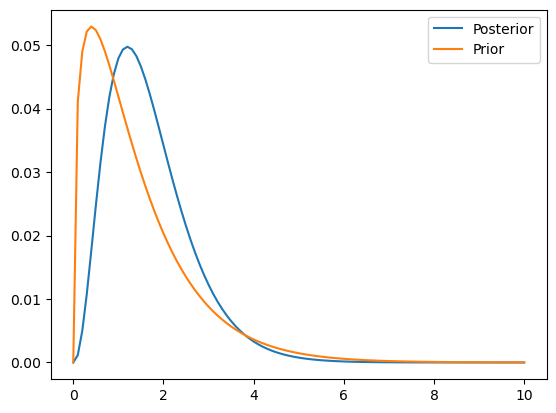

In [85]:
# update (after seeing Croatia score 2 goals)
croatia = prior.copy()
posterior_c = update_poisson(croatia, 2)   

posterior_c.plot()
plt.plot(prior.qs, prior.ps)
plt.legend(["Posterior", "Prior"])

- Now try to predict the results of a rematch
- We don't know the true goal scoring rate for each team (but we do have a posterior probability distribution).
- We do know how to generate a goal scoring distribution for an individual value of lamda
- so we must first sample from the posterior repeatedly
- and then generate a distribution of goals from that sample

(array([0.00000000e+00, 0.00000000e+00, 1.00002000e-04, 1.40002800e-03,
        7.40014800e-03, 1.80003600e-02, 3.04006080e-02, 4.68009360e-02,
        7.37014740e-02, 9.94019880e-02, 1.28202564e-01, 1.56103122e-01,
        1.92403848e-01, 2.29804596e-01, 2.55605112e-01, 2.78405568e-01,
        3.01806036e-01, 3.23906478e-01, 3.25206504e-01, 3.53307066e-01,
        3.75207504e-01, 3.64707294e-01, 3.66507330e-01, 3.66107322e-01,
        3.75807516e-01, 3.68907378e-01, 3.51807036e-01, 3.36806736e-01,
        3.25006500e-01, 3.12506250e-01, 2.92105842e-01, 2.75705514e-01,
        2.53905078e-01, 2.54505090e-01, 2.31604632e-01, 2.14604292e-01,
        2.02604052e-01, 1.86603732e-01, 1.68603372e-01, 1.53903078e-01,
        1.40702814e-01, 1.27302546e-01, 1.18602372e-01, 1.11202224e-01,
        1.04102082e-01, 9.05018100e-02, 7.36014720e-02, 7.37014740e-02,
        6.56013120e-02, 5.41010820e-02, 4.74009480e-02, 4.64009280e-02,
        3.90007800e-02, 3.57007140e-02, 3.47006940e-02, 2.580051

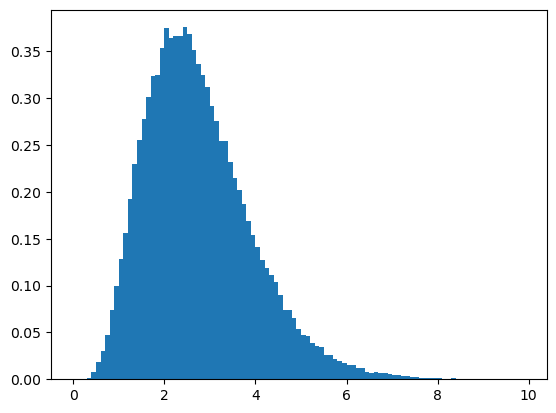

In [129]:
# first sample from the posterior
samples = posterior_f.sample(10**5)
plt.hist(samples, density=True, bins=np.arange(0,10,0.1))

In [139]:
# now for each sample of lambda, you must generate a poisson
# and then you must average those
import pandas as pd
post_pred_dists = pd.DataFrame([make_poisson_pmf(lam, np.arange(10)) 
  for lam in samples[:101] ])

In [140]:
post_pred_dists.T

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.246598,0.301194,4.493290e-01,0.036964,0.045112,0.002969,0.011302,0.030298,0.301194,0.090736,0.082108,0.100273,0.122465,0.272532,4.065697e-01,0.135342,0.332871,0.122465,0.090736,0.135342,0.165302,0.201898,0.049842,0.074301,0.082108,0.100273,0.090736,0.010252,0.015164,4.065697e-01,0.182686,0.055070,0.110814,0.030298,0.110814,0.005222,0.110814,0.030298,0.149573,0.272532,...,0.055070,0.074301,0.272532,0.049842,0.022501,0.272532,0.165302,0.036964,0.055070,0.045112,0.036964,0.301194,0.122465,0.122465,0.022501,0.049842,0.182686,0.055070,0.082108,0.165302,0.018466,0.165302,0.055070,0.067239,0.272532,0.100273,0.036964,0.246598,0.006959,0.030298,0.045112,0.082108,4.965853e-01,0.040834,0.040834,0.036964,0.223131,0.033464,0.009302,0.201898
1,0.345237,0.361433,3.594632e-01,0.121982,0.139848,0.017515,0.050860,0.106042,0.361433,0.217767,0.205269,0.230629,0.257176,0.354292,3.659127e-01,0.270683,0.366158,0.257176,0.217767,0.270683,0.297544,0.323037,0.149526,0.193184,0.205269,0.230629,0.217767,0.047159,0.063690,3.659127e-01,0.310566,0.159704,0.243792,0.106042,0.243792,0.027675,0.243792,0.106042,0.284189,0.354292,...,0.159704,0.193184,0.354292,0.149526,0.085505,0.354292,0.297544,0.121982,0.159704,0.139848,0.121982,0.361433,0.257176,0.257176,0.085505,0.149526,0.310566,0.159704,0.205269,0.297544,0.073863,0.297544,0.159704,0.181546,0.354292,0.230629,0.121982,0.345237,0.034797,0.106042,0.139848,0.205269,3.476097e-01,0.130669,0.130669,0.121982,0.334697,0.113777,0.043719,0.323037
2,0.241666,0.216860,1.437853e-01,0.201271,0.216765,0.051670,0.114435,0.185574,0.216860,0.261320,0.256587,0.265223,0.270035,0.230290,1.646607e-01,0.270683,0.201387,0.270035,0.261320,0.270683,0.267789,0.258429,0.224289,0.251139,0.256587,0.265223,0.261320,0.108466,0.133749,1.646607e-01,0.263981,0.231571,0.268171,0.185574,0.268171,0.073338,0.268171,0.185574,0.269980,0.230290,...,0.231571,0.251139,0.230290,0.224289,0.162459,0.230290,0.267789,0.201271,0.231571,0.216765,0.201271,0.216860,0.270035,0.270035,0.162459,0.224289,0.263981,0.231571,0.256587,0.267789,0.147726,0.267789,0.231571,0.245087,0.230290,0.265223,0.201271,0.241666,0.086993,0.185574,0.216765,0.256587,1.216634e-01,0.209071,0.209071,0.201271,0.251022,0.193421,0.102739,0.258429
3,0.112777,0.086744,3.834274e-02,0.221398,0.223991,0.101617,0.171652,0.216503,0.086744,0.209056,0.213822,0.203337,0.189025,0.099792,4.939822e-02,0.180455,0.073842,0.189025,0.209056,0.180455,0.160674,0.137829,0.224289,0.217654,0.213822,0.203337,0.209056,0.166315,0.187249,4.939822e-02,0.149589,0.223852,0.196659,0.216503,0.196659,0.129564,0.196659,0.216503,0.170987,0.099792,...,0.223852,0.217654,0.099792,0.224289,0.205782,0.099792,0.160674,0.221398,0.223852,0.223991,0.221398,0.086744,0.189025,0.189025,0.205782,0.224289,0.149589,0.223852,0.213822,0.160674,0.196969,0.160674,0.223852,0.220578,0.099792,0.203337,0.221398,0.112777,0.144989,0.216503,0.223991,0.213822,2.838813e-02,0.223009,0.223009,0.221398,0.125511,0.219211,0.160957,0.137829
4,0.039472,0.026023,7.668548e-03,0.182653,0.173593,0.149885,0.193108,0.189440,0.026023,0.125434,0.133639,0.116919,0.099238,0.032432,1.111460e-02,0.090228,0.020307,0.099238,0.125434,0.090228,0.072303,0.055132,0.168217,0.141475,0.133639,0.116919,0.125434,0.191263,0.196611,1.111460e-02,0.063575,0.162293,0.108162,0.189440,0.108162,0.171672,0.108162,0.189440,0.081219,0.032432,...,0.162293,0.141475,0.032432,0.168217,0.195492,0.032432,0.072303,0.182653,0.162293,0.173593,0.182653,0.026023,0.099238,0.099238,0.195492,0.168217,0.063575,0.162293,0.133639,0.072303,0.196969,0.072303,0.162293,0.148890,0.032432,0.116919,0.182653,0.039472,0.181236,0.189440,0.173593,0.133639,4.967922e-03,0.178407,0.178407,0.182653,0.047067,0.186329,0.189125,0.055132
5,0.011052,0.006246,1.226968e-03,0.120551,0.107627,0.176864,0.173798,0.132608,0.006246,0.060208,0.066819,0.053783,0.041680,0.008432,2.000628e-03,0.036091,0.004467,0.041680,0.060208,0.036091,0.026029,0.0176

In [142]:
(post_pred_dists.T * np.array(france)).sum(axis=1)

0    0.006444
1    0.011323
2    0.011493
3    0.008816
4    0.005671
5    0.003244
6    0.001715
7    0.000856
8    0.000408
9    0.000186
dtype: float64